In [1]:
import sys
sys.path.append("/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration")
import gain_utils as gu
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

folder = "/dipc/elena/WCTE_2025_commissioning/parquet_files"
run_number = "led_scan_calibration_20250404145411_hv_0_20250404145412_7"

df_wf = gu.load_waveforms(folder, run_number)
df_led = gu.load_led(folder, run_number)

In [ ]:
df_wf.head()
df_wf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18472900 entries, 0 to 18472899
Data columns (total 16 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   flags             uint32
 1   chan              uint32
 2   num_samples       uint32
 3   num_bytes         uint32
 4   wave_no           uint32
 5   hit_no            uint32
 6   lsb_coarse        uint32
 7   msb_coarse        uint32
 8   coarse            uint64
 9   card_id           uint32
 10  pkt_num           uint32
 11  max_sample        int32 
 12  max_sample_pos    int32 
 13  sample_integral8  int32 
 14  samples           object
 15  card_mismatch     bool  
dtypes: bool(1), int32(3), object(1), uint32(10), uint64(1)
memory usage: 1.2+ GB


In [3]:
print(df_led.columns)
print(df_led.head(10))

Index(['led_no', 'gain', 'dac', 'seq_no', 'seq_type', 'lsb_coarse',
       'msb_coarse', 'coarse', 'card_id', 'pkt_num', 'card_mismatch'],
      dtype='object')
   led_no  gain  dac  seq_no  seq_type  lsb_coarse  msb_coarse      coarse  \
0       1     1  750    8873         0   660296486      141146  9250231078   
1       1     1  750    8874         0   660358986      141146  9250293578   
2       1     1  750    8875         0   660421486      141146  9250356078   
3       1     1  750    8876         0   660483986      141146  9250418578   
4       1     1  750    8877         0   660546486      141146  9250481078   
5       1     1  750    8878         0   660608986      141146  9250543578   
6       1     1  750    8879         0   660671486      141146  9250606078   
7       1     1  750    8880         0   660733986      141146  9250668578   
8       1     1  750    8881         0   660796486      141146  9250731078   
9       1     1  750    8882         0   660858986      141

In [4]:
card_id = 1
chan = 1

df_sel = df_wf[(df_wf['card_id'] == card_id) & (df_wf['chan'] == chan)]

print(f"Selected {len(df_sel)} waveforms")

# Convert lists to 2D NumPy array: (n_waveforms, n_samples)
waveforms = np.stack(df_sel['samples'].to_numpy())
print("Waveforms shape:", waveforms.shape)   #waveforms with 32 samples this time 

Selected 11127 waveforms
Waveforms shape: (11127, 32)


In [5]:
waveforms_bs = np.array([gu.baseline_subtract(wf) for wf in waveforms])  #electronic baseline subtraction

#compute CFD time for each waveform
cfd_times = np.array([gu.get_cfd(wf)[0] for wf in waveforms_bs])  #we take the first element from (t, amp, baseline)

#choose a reference bin for alignment
target_bin = 15

#convert CFD time to nearest bin (assuming 1 bin = 1 ADC sample)
cfd_bins = np.rint(cfd_times).astype(int)

#shift waveforms to align the CFD peaks
aligned_wfs = np.zeros_like(waveforms_bs)
for i, wf in enumerate(waveforms_bs):
    shift = target_bin - cfd_bins[i]
    aligned_wfs[i] = np.roll(wf, shift)

mean_wf = np.mean(aligned_wfs, axis=0)

y_min = min(waveforms.min(), aligned_wfs.min(), mean_wf.min())
y_max = max(waveforms.max(), aligned_wfs.max(), mean_wf.max())


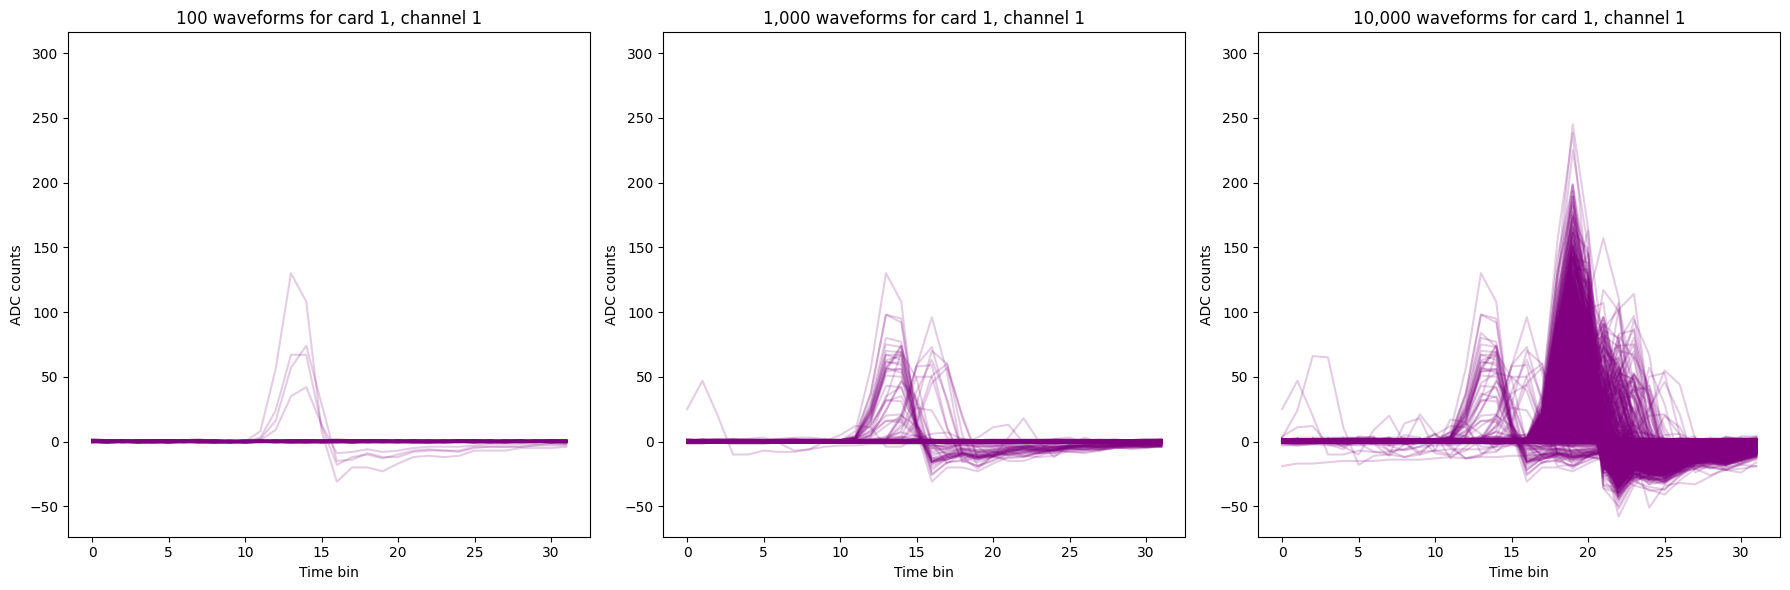

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))


for i in range(min(100, waveforms.shape[0])):  
    axes[0].plot(waveforms[i], color='purple', alpha=0.2)
axes[0].set_xlabel("Time bin")
axes[0].set_ylabel("ADC counts")
axes[0].set_title(f"100 waveforms for card {card_id}, channel {chan}")
axes[0].set_ylim(y_min, y_max)

# Aligned waveforms
for i in range(min(1000, waveforms.shape[0])):
    axes[1].plot(waveforms[i], color='purple', alpha=0.2)
axes[1].set_xlabel("Time bin")
axes[1].set_ylabel("ADC counts")
axes[1].set_title(f"1,000 waveforms for card {card_id}, channel {chan}")
axes[1].set_ylim(y_min, y_max)

# Mean aligned waveform
for i in range(min(10000, waveforms.shape[0])):
    axes[2].plot(waveforms[i], color='purple', alpha=0.2)
axes[2].set_xlabel("Time bin")
axes[2].set_ylabel("ADC counts")
axes[2].set_title(f"10,000 waveforms for card {card_id}, channel {chan}")
axes[2].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

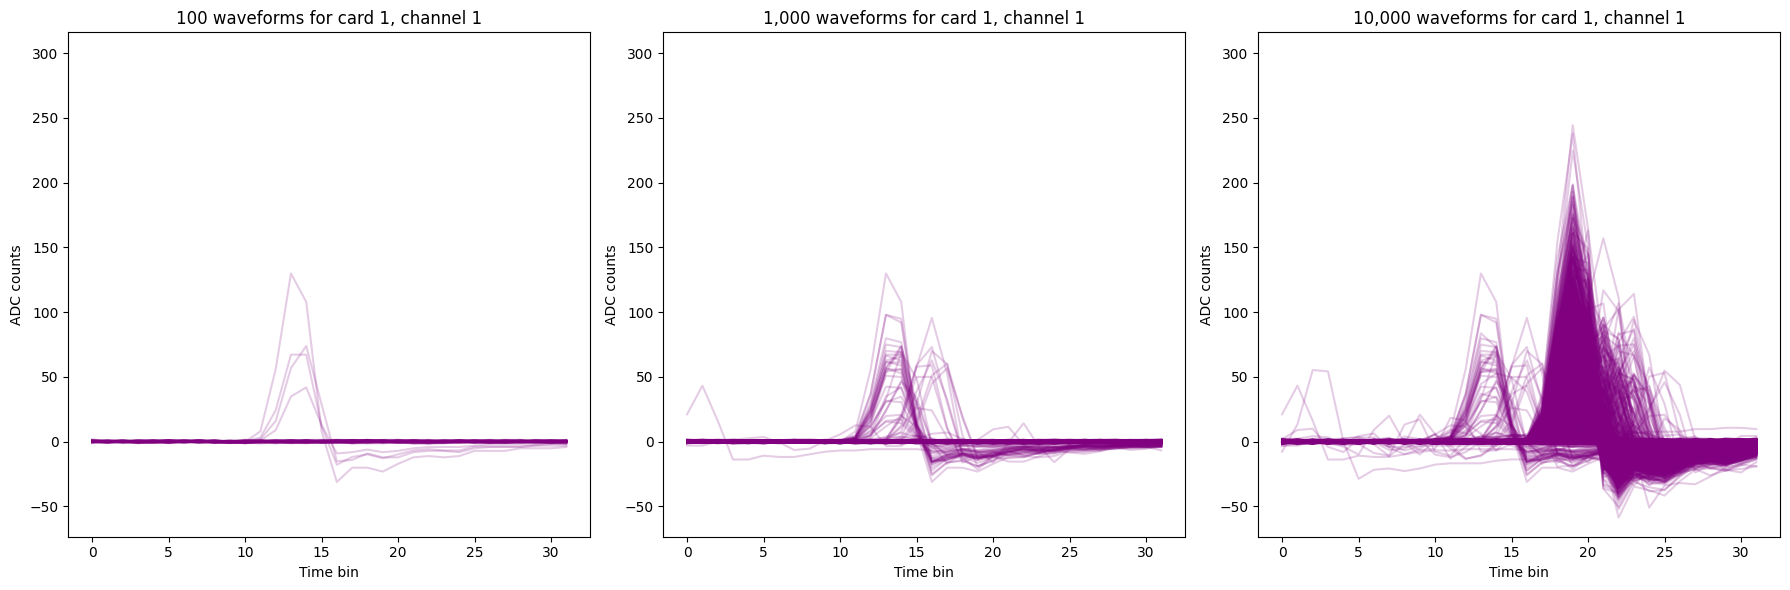

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))


for i in range(min(100, waveforms.shape[0])):  
    axes[0].plot(waveforms_bs[i], color='purple', alpha=0.2)
axes[0].set_xlabel("Time bin")
axes[0].set_ylabel("ADC counts")
axes[0].set_title(f"100 waveforms for card {card_id}, channel {chan}")
axes[0].set_ylim(y_min, y_max)

# Aligned waveforms
for i in range(min(1000, waveforms.shape[0])):
    axes[1].plot(waveforms_bs[i], color='purple', alpha=0.2)
axes[1].set_xlabel("Time bin")
axes[1].set_ylabel("ADC counts")
axes[1].set_title(f"1,000 waveforms for card {card_id}, channel {chan}")
axes[1].set_ylim(y_min, y_max)

# Mean aligned waveform
for i in range(min(10000, waveforms.shape[0])):
    axes[2].plot(waveforms_bs[i], color='purple', alpha=0.2)
axes[2].set_xlabel("Time bin")
axes[2].set_ylabel("ADC counts")
axes[2].set_title(f"10,000 waveforms for card {card_id}, channel {chan}")
axes[2].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

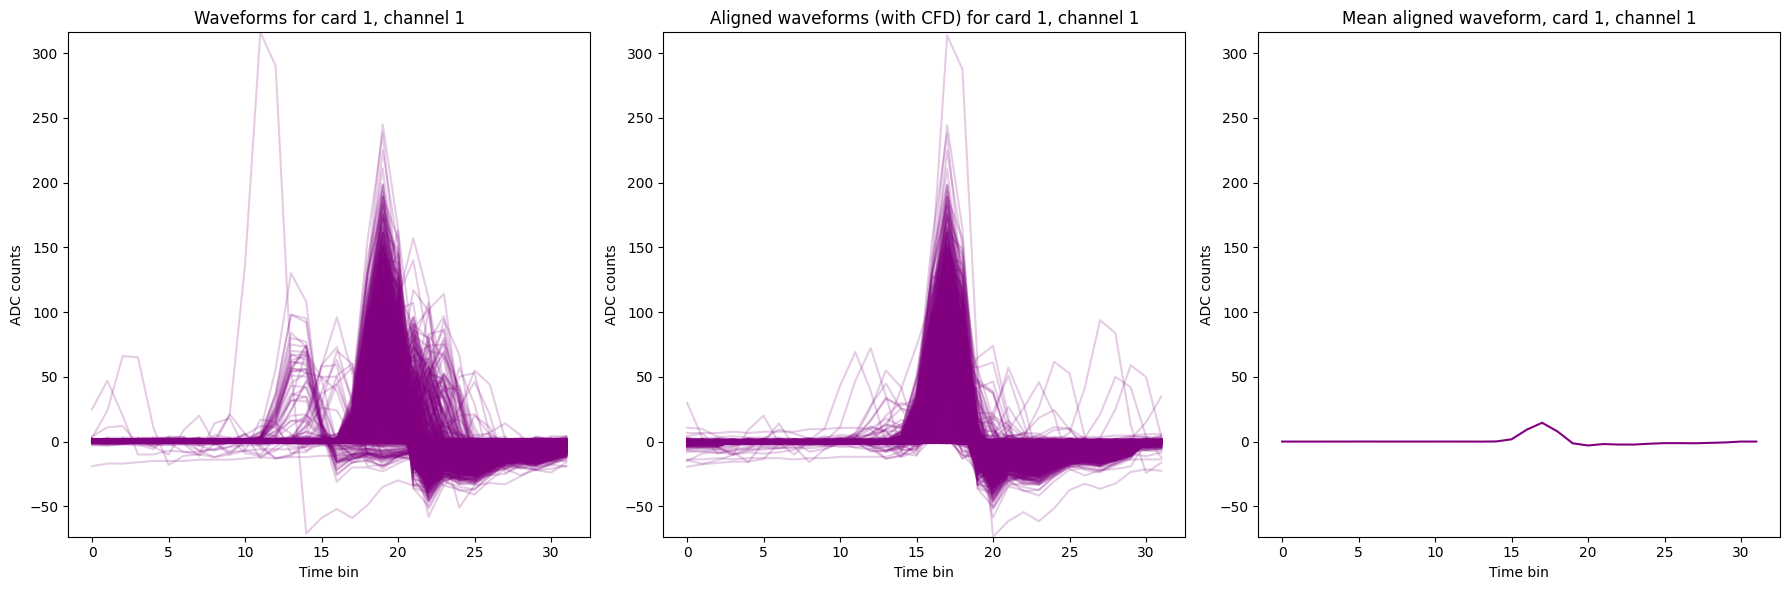

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))


for i in range(min(11127, waveforms.shape[0])):  
    axes[0].plot(waveforms[i], color='purple', alpha=0.2)
axes[0].set_xlabel("Time bin")
axes[0].set_ylabel("ADC counts")
axes[0].set_title(f"Waveforms for card {card_id}, channel {chan}")
axes[0].set_ylim(y_min, y_max)

# Aligned waveforms
for i in range(min(11127, aligned_wfs.shape[0])):
    axes[1].plot(aligned_wfs[i], color='purple', alpha=0.2)
axes[1].set_xlabel("Time bin")
axes[1].set_ylabel("ADC counts")
axes[1].set_title(f"Aligned waveforms (with CFD) for card {card_id}, channel {chan}")
axes[1].set_ylim(y_min, y_max)

# Mean aligned waveform
axes[2].plot(mean_wf, color='purple')
axes[2].set_xlabel("Time bin")
axes[2].set_ylabel("ADC counts")
axes[2].set_title(f"Mean aligned waveform, card {card_id}, channel {chan}")
axes[2].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [9]:
print(len(waveforms_bs))
print(len(aligned_wfs))

11127
11127


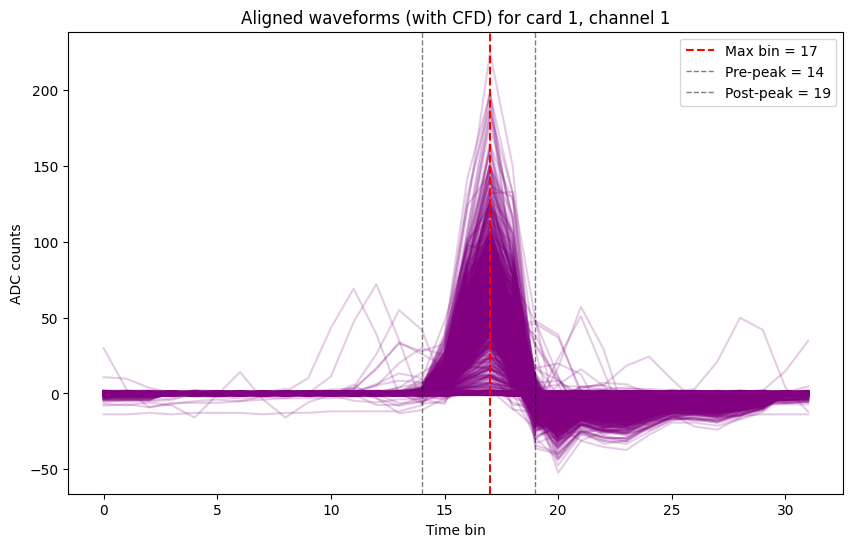

In [10]:
threshold = 10  # ADC counts, ajustar según convenga

#índice del pico para cada waveform, solo si supera el threshold
peak_bins = [np.argmax(wf) for wf in aligned_wfs if np.max(wf) > threshold]

#bin con el máximo número de picos válidos
max_bin = np.bincount(peak_bins).argmax()
pre_peak = max_bin - 3
post_peak = max_bin + 2

plt.figure(figsize=(10,6))

for i in range(min(5000, aligned_wfs.shape[0])):
    plt.plot(aligned_wfs[i], color='purple', alpha=0.2)

plt.xlabel("Time bin")
plt.ylabel("ADC counts")
plt.title(f"Aligned waveforms (with CFD) for card {card_id}, channel {chan}")

plt.axvline(max_bin, color='red', linestyle='--', lw=1.5, label=f"Max bin = {max_bin}")
plt.axvline(pre_peak, color='k', linestyle='--', lw=1, alpha=0.5, label=f"Pre-peak = {pre_peak}")
plt.axvline(post_peak, color='k', linestyle='--', lw=1, alpha=0.5, label=f"Post-peak = {post_peak}")

plt.legend()
plt.show()

In [11]:
mean_peak = np.argmax(mean_wf)
half_max = mean_wf[mean_peak] / 2
# find left/right points where waveform drops below half-max
left = np.where(mean_wf[:mean_peak] < half_max)[0]
right = np.where(mean_wf[mean_peak:] < half_max)[0] + mean_peak
start_bin = left[-1] if len(left) > 0 else 0
end_bin   = right[0] if len(right) > 0 else len(mean_wf)-1

integration_window = (start_bin, end_bin)

print("mean_peak:",mean_peak)
print("integration_window:",integration_window)

mean_peak: 17
integration_window: (15, 19)


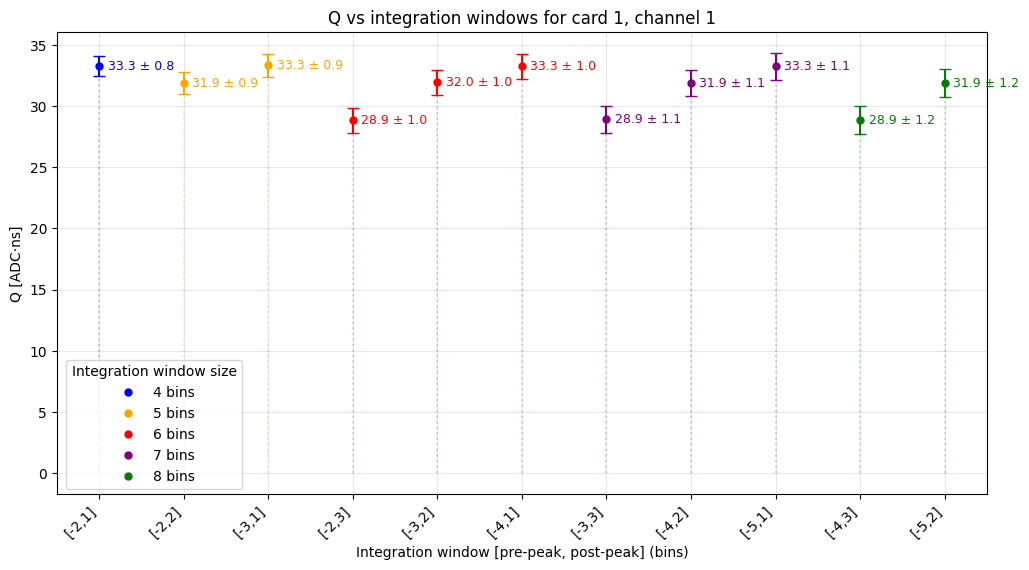


Top 3 candidate integration windows:
Window (-3, 1), bins=5, Q=33.3, σ_Q=0.9, rel_err=2.77%
Window (-4, 1), bins=6, Q=33.3, σ_Q=1.0, rel_err=3.04%
Window (-2, 1), bins=4, Q=33.3, σ_Q=0.8, rel_err=2.48%


In [12]:
#Integration window optimization
from matplotlib.lines import Line2D

threshold = 10  # ADC counts for peak selection

# candidate peak bin for each waveform above threshold
peak_bins = [np.argmax(wf) for wf in aligned_wfs if np.max(wf) > threshold]

# bin with maximum number of valid peaks
max_bin = np.bincount(peak_bins).argmax()

# explore candidate windows around max_bin
bin_sizes = [4, 5, 6, 7, 8]
all_windows = []

for n_bins in bin_sizes:
    for pre in range(1, n_bins):
        post = n_bins - pre - 1
        if post >= 1: #and pre != post:          #discard symmetric windows if all the line; allow them with the #
            all_windows.append((-pre, post))

# compute Q, noise, relative error for each candidate window
results = []

for w in all_windows:
    pre_peak = -w[0]
    post_peak = w[1]
    start = max(0, max_bin - pre_peak)
    end = min(aligned_wfs.shape[1], max_bin + post_peak + 1)
    N = end - start

    #integrated charge for all already aligned waveforms in window
    charges = np.sum(aligned_wfs[:, start:end], axis=1)

    #baseline RMS from first 10 samples
    sigma_bin = np.std(aligned_wfs[:, :10], axis=1)
    sigma_Q = np.mean(np.sqrt(N) * sigma_bin)

    #mean charge
    Q_mean = np.mean(charges)
    rel_err = (sigma_Q / Q_mean) * 100 if Q_mean != 0 else np.nan

    results.append({
        'window': w,
        'start': start,
        'end': end,
        'n_bins': N,
        'Q': Q_mean,
        'noise': sigma_Q,
        'rel_error(%)': rel_err
    })

#filter results for plotting similar to your .root approach
candidate_windows = [(-4,2), (-5,1), (-4,1), (-2,2)]
extra_bins = [4, 5, 6, 7, 8]

plot_results = []
for r in results:
    pre, post = r['window']
    if pre in (-1,-6):
        continue
    if post in (4,5):
        continue
    if r['window'] in candidate_windows or r['n_bins'] in extra_bins:
        plot_results.append(r)

#color map for different window sizes
color_map_bins = {4: 'blue', 5: 'orange', 6: 'red', 7: 'purple', 8: 'green'}

#scatter plot of Q vs window
plt.figure(figsize=(12,6))
x_labels = [f"[{w[0]},{w[1]}]" for w in [r['window'] for r in plot_results]]
x_pos = range(len(plot_results))

for i, r in enumerate(plot_results):
    w = r['window']
    Q = r['Q']
    sigma_Q = r['noise']
    n_bins = r['n_bins']
    color = color_map_bins[n_bins]

    plt.errorbar(
        x_pos[i], Q, yerr=sigma_Q,
        fmt='o', color=color, markersize=5, capsize=4
    )
    plt.vlines(x=x_pos[i], ymin=0, ymax=Q, colors=color, linestyles="dotted", alpha=0.2)
    plt.text(x_pos[i]+0.1, Q, f"{Q:.1f} ± {sigma_Q:.1f}", color=color, fontsize=9, va='center')

plt.xticks(x_pos, x_labels, rotation=45, ha='right')

#legend
custom_lines = [Line2D([0], [0], color=color_map_bins[b], marker='o', lw=0, markersize=5, label=f"{b} bins")
                for b in sorted(color_map_bins.keys())]
plt.legend(handles=custom_lines, title="Integration window size", fontsize=10, loc=(0.01,0.01))

plt.xlabel("Integration window [pre-peak, post-peak] (bins)")
plt.ylabel("Q [ADC·ns]")
plt.title(f"Q vs integration windows for card {card_id}, channel {chan}")
plt.grid(alpha=0.3)
plt.show()



best_candidates = sorted(plot_results, key=lambda r: (-r['Q'], r['rel_error(%)']))[:3]
print("\nTop 3 candidate integration windows:")
for r in best_candidates:
    print(f"Window {r['window']}, bins={r['n_bins']}, Q={r['Q']:.1f}, σ_Q={r['noise']:.1f}, rel_err={r['rel_error(%)']:.2f}%")


/dipc/elena/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


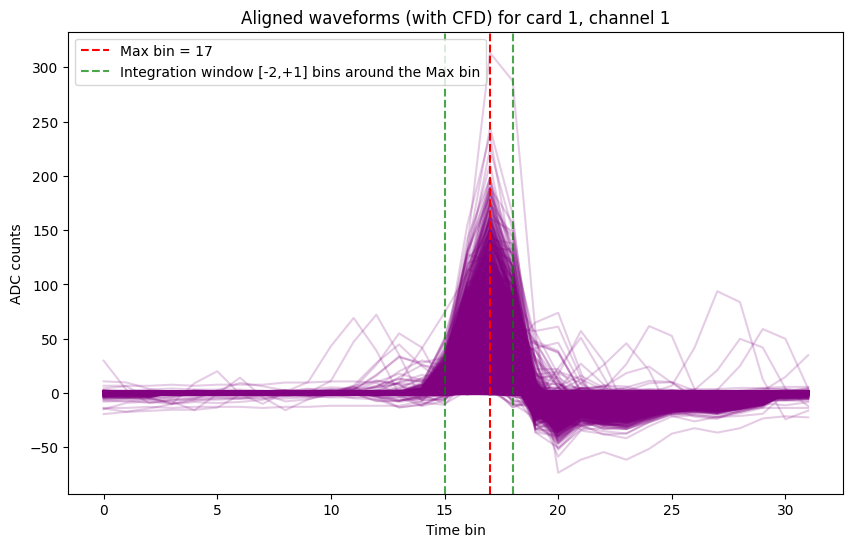

In [13]:
best_window = (-2, 1)  # pre, post
pre_peak = -best_window[0]  # convert to positive offset
post_peak = best_window[1]

threshold = 10
peak_bins = [np.argmax(wf) for wf in aligned_wfs if np.max(wf) > threshold]
max_bin = np.bincount(peak_bins).argmax()  # bin with most peaks

plt.figure(figsize=(10,6))

for i in range(min(11127, aligned_wfs.shape[0])):
    plt.plot(aligned_wfs[i], color='purple', alpha=0.2)

plt.xlabel("Time bin")
plt.ylabel("ADC counts")
plt.title(f"Aligned waveforms (with CFD) for card {card_id}, channel {chan}")


plt.axvline(max_bin, color='red', linestyle='--', lw=1.5, label=f"Max bin = {max_bin}")
plt.axvline(max_bin - pre_peak, color='green', linestyle='--', lw=1.5, alpha=0.7)
plt.axvline(max_bin + post_peak, color='green', linestyle='--', lw=1.5, alpha=0.7, label=f"Integration window [-2,+1] bins around the Max bin")

plt.legend()
plt.show()

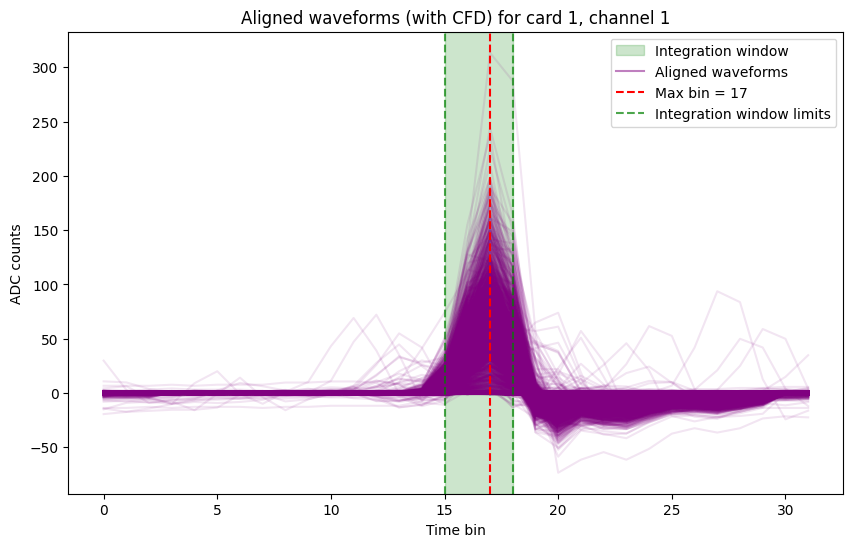

In [14]:
best_window = (-2, 1)  # pre, post
pre_peak = -best_window[0]  # convert to positive offset
post_peak = best_window[1]

threshold = 10
peak_bins = [np.argmax(wf) for wf in aligned_wfs if np.max(wf) > threshold]
max_bin = np.bincount(peak_bins).argmax()  # bin with most peaks

plt.figure(figsize=(10,6))

#highlight integration window
plt.axvspan(max_bin - pre_peak, max_bin + post_peak, color='green', alpha=0.2, label="Integration window")


n_plot = min(11127, aligned_wfs.shape[0])
for i in range(n_plot):
    if i == 0:
        plt.plot(aligned_wfs[i], color='purple', alpha=0.5, label="Aligned waveforms")
    else:
        plt.plot(aligned_wfs[i], color='purple', alpha=0.1)



plt.xlabel("Time bin")
plt.ylabel("ADC counts")
plt.title(f"Aligned waveforms (with CFD) for card {card_id}, channel {chan}")


plt.axvline(max_bin, color='red', linestyle='--', lw=1.5, label=f"Max bin = {max_bin}")
plt.axvline(max_bin - pre_peak, color='green', linestyle='--', lw=1.5, alpha=0.7)
plt.axvline(max_bin + post_peak, color='green', linestyle='--', lw=1.5, alpha=0.7, label="Integration window limits")

plt.legend()
plt.show()

In [15]:
# Baseline subtraction
waveforms_bs = np.array([gu.baseline_subtract(wf) for wf in aligned_wfs])

threshold = 10  # ADC counts

# Calcular la carga integrada condicionalmente
signal_charges = np.array([
    gu.integrate_waveform_control(wf) if np.max(wf) <= threshold
    else gu.integrate_waveform_signal(wf, pre_peak=2, post_peak=1)
    for wf in waveforms_bs
])

# Fit unbinned double Gaussian
fit_results = gu.fit_double_gauss_multistart(signal_charges)
mu1, sigma1 = fit_results["mu1"], fit_results["sigma1"]
mu2, sigma2 = fit_results["mu2"], fit_results["sigma2"]
w = fit_results["w"]

# Función PDF doble Gaussiana
def double_gauss_pdf(x, mu1, sigma1, mu2, sigma2, w):
    return w * norm.pdf(x, mu1, sigma1) + (1-w) * norm.pdf(x, mu2, sigma2)

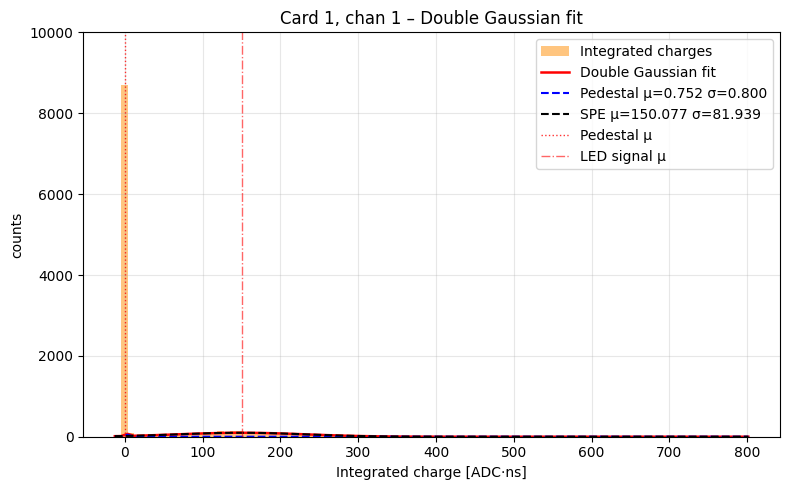

For card_id=1 channel=1: mu1=0.752, sigma1=0.800, mu2=150.077, sigma2=81.939, w=0.781


In [16]:
plt.figure(figsize=(8,5))
bins = np.linspace(signal_charges.min() - 5, signal_charges.max() + 5, 100)
counts, bins_hist, _ = plt.hist(signal_charges, bins=bins, color="darkorange", alpha=0.5, label="Integrated charges", density=False)

bin_width = bins[1] - bins[0]
N = len(signal_charges)
x_vals = np.linspace(bins[0], bins[-1], 100)

pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

pdf_total_counts = pdf_total * N * bin_width
pdf_ped_counts   = pdf_ped * N * bin_width
pdf_spe_counts   = pdf_spe * N * bin_width

plt.plot(x_vals, pdf_total_counts, 'r-', lw=1.8, label="Double Gaussian fit")
plt.plot(x_vals, pdf_ped_counts, 'b--', lw=1.5, label=f"Pedestal μ={mu1:.3f} σ={sigma1:.3f}")
plt.plot(x_vals, pdf_spe_counts, 'k--', lw=1.5, label=f"SPE μ={mu2:.3f} σ={sigma2:.3f}")

plt.axvline(mu1, color='red', linestyle=':', lw=1, alpha=0.8, label= "Pedestal μ")
plt.axvline(mu2, color='red', linestyle='-.', lw=1, alpha=0.6, label="LED signal μ")

plt.ylim(0, np.max(counts)*1.15)
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("counts")
plt.title(f"Card {card_id}, chan {chan} – Double Gaussian fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

print(f"For card_id={card_id} channel={chan}: mu1={mu1:.3f}, sigma1={sigma1:.3f}, mu2={mu2:.3f}, sigma2={sigma2:.3f}, w={w:.3f}")

In [ ]:
min_negative = np.min(signal_charges[signal_charges < 0])
print(min_negative)

-7.800000000000002


In [ ]:
print(signal_charges[signal_charges < 0])
print(len(signal_charges[signal_charges < 0]))
print(len(signal_charges[signal_charges >= 0]))

[-4.00000000e-01 -2.00000000e-01 -1.38777878e-17 ... -2.00000000e-01
 -6.00000000e-01 -2.00000000e-01]
1075
10052


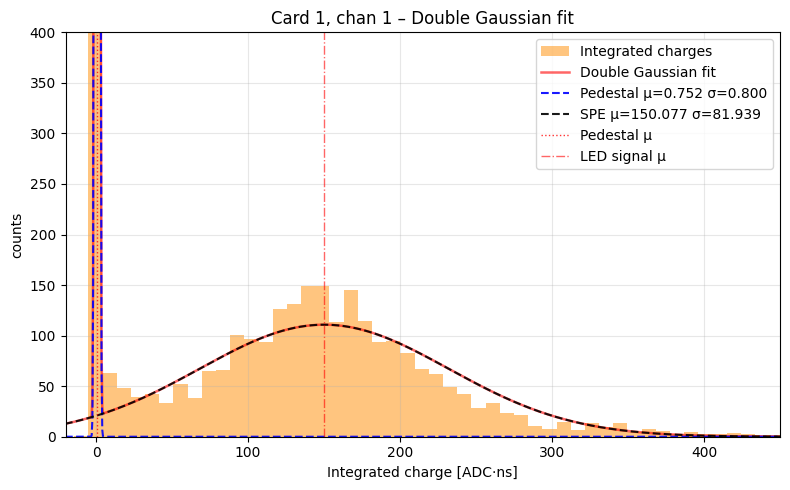

In [19]:
plt.figure(figsize=(8,5))
bins = np.linspace(signal_charges.min() - 100, signal_charges.max() + 20, 100)
counts, bins_hist, _ = plt.hist(signal_charges, bins=bins, color="darkorange", alpha=0.5, label="Integrated charges", density=False)

bin_width = bins[1] - bins[0]
N = len(signal_charges)
x_vals = np.linspace(bins[0], bins[-1], 2000)

pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

pdf_total_counts = pdf_total * N * bin_width
pdf_ped_counts   = pdf_ped * N * bin_width
pdf_spe_counts   = pdf_spe * N * bin_width

plt.plot(x_vals, pdf_total_counts, 'r-', lw=1.8, alpha=0.6, label="Double Gaussian fit")
plt.plot(x_vals, pdf_ped_counts, 'b--', lw=1.5, alpha=0.9, label=f"Pedestal μ={mu1:.3f} σ={sigma1:.3f}")
plt.plot(x_vals, pdf_spe_counts, 'k--', lw=1.5, alpha=0.9, label=f"SPE μ={mu2:.3f} σ={sigma2:.3f}")

plt.axvline(mu1, color='red', linestyle=':', lw=1, alpha=0.8, label= "Pedestal μ")
plt.axvline(mu2, color='red', linestyle='-.', lw=1, alpha=0.6, label="LED signal μ")

plt.ylim(0, 400)
plt.xlim(-20,450)
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("counts")
plt.title(f"Card {card_id}, chan {chan} – Double Gaussian fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
unique_pmts = df_wf[["card_id","chan"]].drop_duplicates()
print(f"Number of unique PMTs with data: {len(unique_pmts)}")

print(unique_pmts.head(20))

Number of unique PMTs with data: 1660
    card_id  chan
0        80     0
1        80     1
2        80     2
3        80     3
4        80     4
5        80     5
6        80     6
7        80     7
8        80     8
9        80     9
10       80    10
11       80    11
12       80    12
13       80    13
14       80    14
15       80    15
16       80    16
17       80    17
18       80    18
19       80    19
